
<br>
<font face="Times New Roman">
<div dir=ltr align=center>
<font color=3C99D size=5>
          PINN for Coupled Spring-Mass System <br>

    
    

# Model architecture  
Our neural network's architecture is a simple feed-forward structure designed to approximate the function $x_i(t)$, mapping time $t$ to the positions of the masses.

### Input and Output

- **Input:** Time $t$.
- **Output:** Positions $x = (x_1(t), x_2(t), \ldots, x_N(t))$.

# Imports

In [84]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from scipy.integrate import solve_ivp
from tqdm import tqdm

# System configuration

In [85]:
N = 3  # Number of masses
alpha = 1.0  # Constant α = k/m
T = 10.0  # Total time
epsilon = 0.1  # Small value for initial condition time window
x0 = 1.0  # Initial displacement of the first mass

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data generation (10 Points)
In this section we'll generate uniform data points for $0<t<T$ to train the model.  
We also need to append some additional initial time ($t=0$) data for the model to learn initial conditions better.

In [ ]:
num_train = 20000  # Number of training samples
num_val = 1000    # Number of validation samples


t_train = np.random.uniform(0, T, num_train)
t_val = np.random.uniform(0, T, num_val)

num_init = 100
t_init = np.random.uniform(0, epsilon, num_init)
t_train = np.concatenate((t_train, t_init))

In [87]:
t_train_tensor = torch.tensor(t_train.reshape(-1, 1), dtype=torch.float32, requires_grad=True).to(device)
t_val_tensor = torch.tensor(t_val.reshape(-1, 1), dtype=torch.float32, requires_grad=True).to(device)

# Model (25 Points)
In this section you need to implement the PINN and create an instance of it.

In [ ]:
class PINN(nn.Module):
    def __init__(self, num_masses: int, num_hidden_layers: int = 4, num_neurons: int = 64):
        super(PINN, self).__init__()

        layers = []
        layers.append(nn.Linear(1, num_neurons))
        layers.append(nn.Tanh())
        for _ in range(num_hidden_layers - 1):
            layers.append(nn.Linear(num_neurons, num_neurons))
            layers.append(nn.Tanh())
        layers.append(nn.Linear(num_neurons, num_masses))
        self.model = nn.Sequential(*layers)

    def forward(self, t: torch.Tensor) -> torch.Tensor:
        x = self.model(t)
        return x

model = PINN(num_masses=N).to(device)
print(model)

PINN(
  (model): Sequential(
    (0): Linear(in_features=1, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): Tanh()
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): Tanh()
    (8): Linear(in_features=64, out_features=3, bias=True)
  )
)


# Custom Loss (30 Points) 
In this section you need to implement the custom loss for the PINN.

In [ ]:
def physics_informed_loss(model: nn.Module, t: torch.Tensor) -> torch.Tensor:
    # Ensure t requires gradients
    t.requires_grad_(True)
    
    # Forward pass to get positions
    x = model(t)
    
    # Initialize tensors to hold first and second derivatives
    x_t = torch.zeros_like(x)
    x_tt = torch.zeros_like(x)
    
    for i in range(N):
        x_t[:, i] = torch.autograd.grad(x[:, i], t, grad_outputs=torch.ones_like(x[:, i]), create_graph=True)[0][:, 0]
        x_tt[:, i] = torch.autograd.grad(x_t[:, i], t, grad_outputs=torch.ones_like(x_t[:, i]), create_graph=True)[0][:, 0]
    

    residuals = torch.zeros_like(x)
    for i in range(N):
        if i == 0:
            residuals[:, i] = x_tt[:, i] - alpha * (x[:, i + 1] - 2 * x[:, i])
        elif i == N - 1:
            residuals[:, i] = x_tt[:, i] - alpha * (x[:, i - 1] - 2 * x[:, i])
        else:
            residuals[:, i] = x_tt[:, i] - alpha * (x[:, i - 1] - 2 * x[:, i] + x[:, i + 1])
    
    loss_phys = torch.mean(residuals ** 2)
    return loss_phys

In [ ]:
def initial_condition_loss(model: nn.Module, t: torch.Tensor) -> torch.Tensor:
    t.requires_grad_(True)
    
    # Forward pass to get positions
    x = model(t)
    
    # Initialize tensor to hold first derivatives (velocities)
    x_t = torch.zeros_like(x)

    for i in range(N):
        x_t[:, i] = torch.autograd.grad(x[:, i], t, grad_outputs=torch.ones_like(x[:, i]), create_graph=True)[0][:, 0]

    
    x_init_true = torch.zeros_like(x)
    x_init_true[:, 0] = -x0  
    loss_pos = torch.mean((x - x_init_true) ** 2)
    loss_vel = torch.mean(x_t ** 2)
    
    loss_ic = loss_pos + loss_vel
    return loss_ic

# Training (20 Points)
Train the model at least 3000 epochs. Also save train and validation loss every few epochs and plot it afterwards.

In [91]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 8000  # Adjust as needed

In [ ]:
# Initialize lists to track training progress
loss_history = []
val_loss_history = []
epochs = []

for epoch in tqdm(range(num_epochs)):
    model.train()
    
    loss_pde = physics_informed_loss(model, t_train_tensor)
    loss_ic = initial_condition_loss(model, t_train_tensor[t_train_tensor[:, 0] <= epsilon])  # Use points near t=0
    loss = loss_pde + loss_ic

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Record training loss
    loss_history.append(loss.item())

    if (epoch + 1) % 500 == 0 or epoch == 0:
        # Set model to evaluation mode
        model.eval()
        val_loss_pde = physics_informed_loss(model, t_val_tensor)
        val_loss_ic = initial_condition_loss(model, t_val_tensor[t_val_tensor[:, 0] <= epsilon])
        val_loss = val_loss_pde + val_loss_ic
        val_loss_history.append(val_loss.item())
        epochs.append(epoch + 1)

100%|██████████| 8000/8000 [04:19<00:00, 30.78it/s]


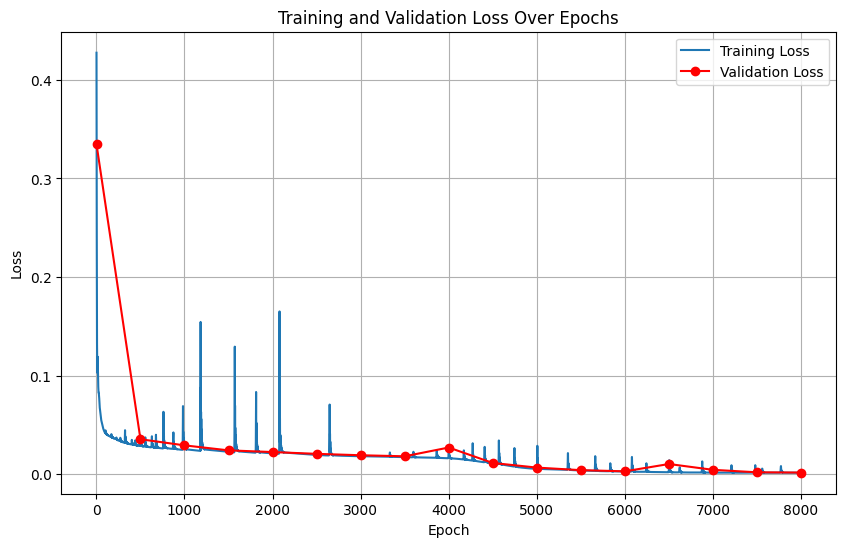

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), loss_history, label='Training Loss')
plt.plot(epochs, val_loss_history, 'ro-', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Evaluation (15 Points)
In this section you need to solve the system using a automatic ODE solver and compare the PINN predictions with the ODE solver results.  
We will use scipy solve_ivp. Do a bit of a research on it and then code this section.

In [94]:
def mass_spring_system(t, y):
    dydt = np.zeros(N * 2)
    x = y[:N]
    v = y[N:]

    for i in range(N):
        if i == 0:
            a = alpha * (x[1] - 2 * x[0])
        elif i == N - 1:
            a = alpha * (x[N - 2] - 2 * x[N - 1])
        else:
            a = alpha * (x[i - 1] - 2 * x[i] + x[i + 1])
        dydt[i] = v[i]
        dydt[N + i] = a
    return dydt

In [95]:
# Initial Conditions for ODE Solver
x_init = np.zeros(N)
x_init[0] = -x0
v_init = np.zeros(N)
y0 = np.concatenate((x_init, v_init))

In [ ]:
t_eval = np.linspace(0, T, 1000)
solution = solve_ivp(mass_spring_system, [0, T], y0, t_eval=t_eval, method='RK45')

model.eval()
t_test_tensor = torch.tensor(t_eval.reshape(-1, 1), dtype=torch.float32).to(device)
with torch.no_grad():
    x_pred = model(t_test_tensor).cpu().numpy()

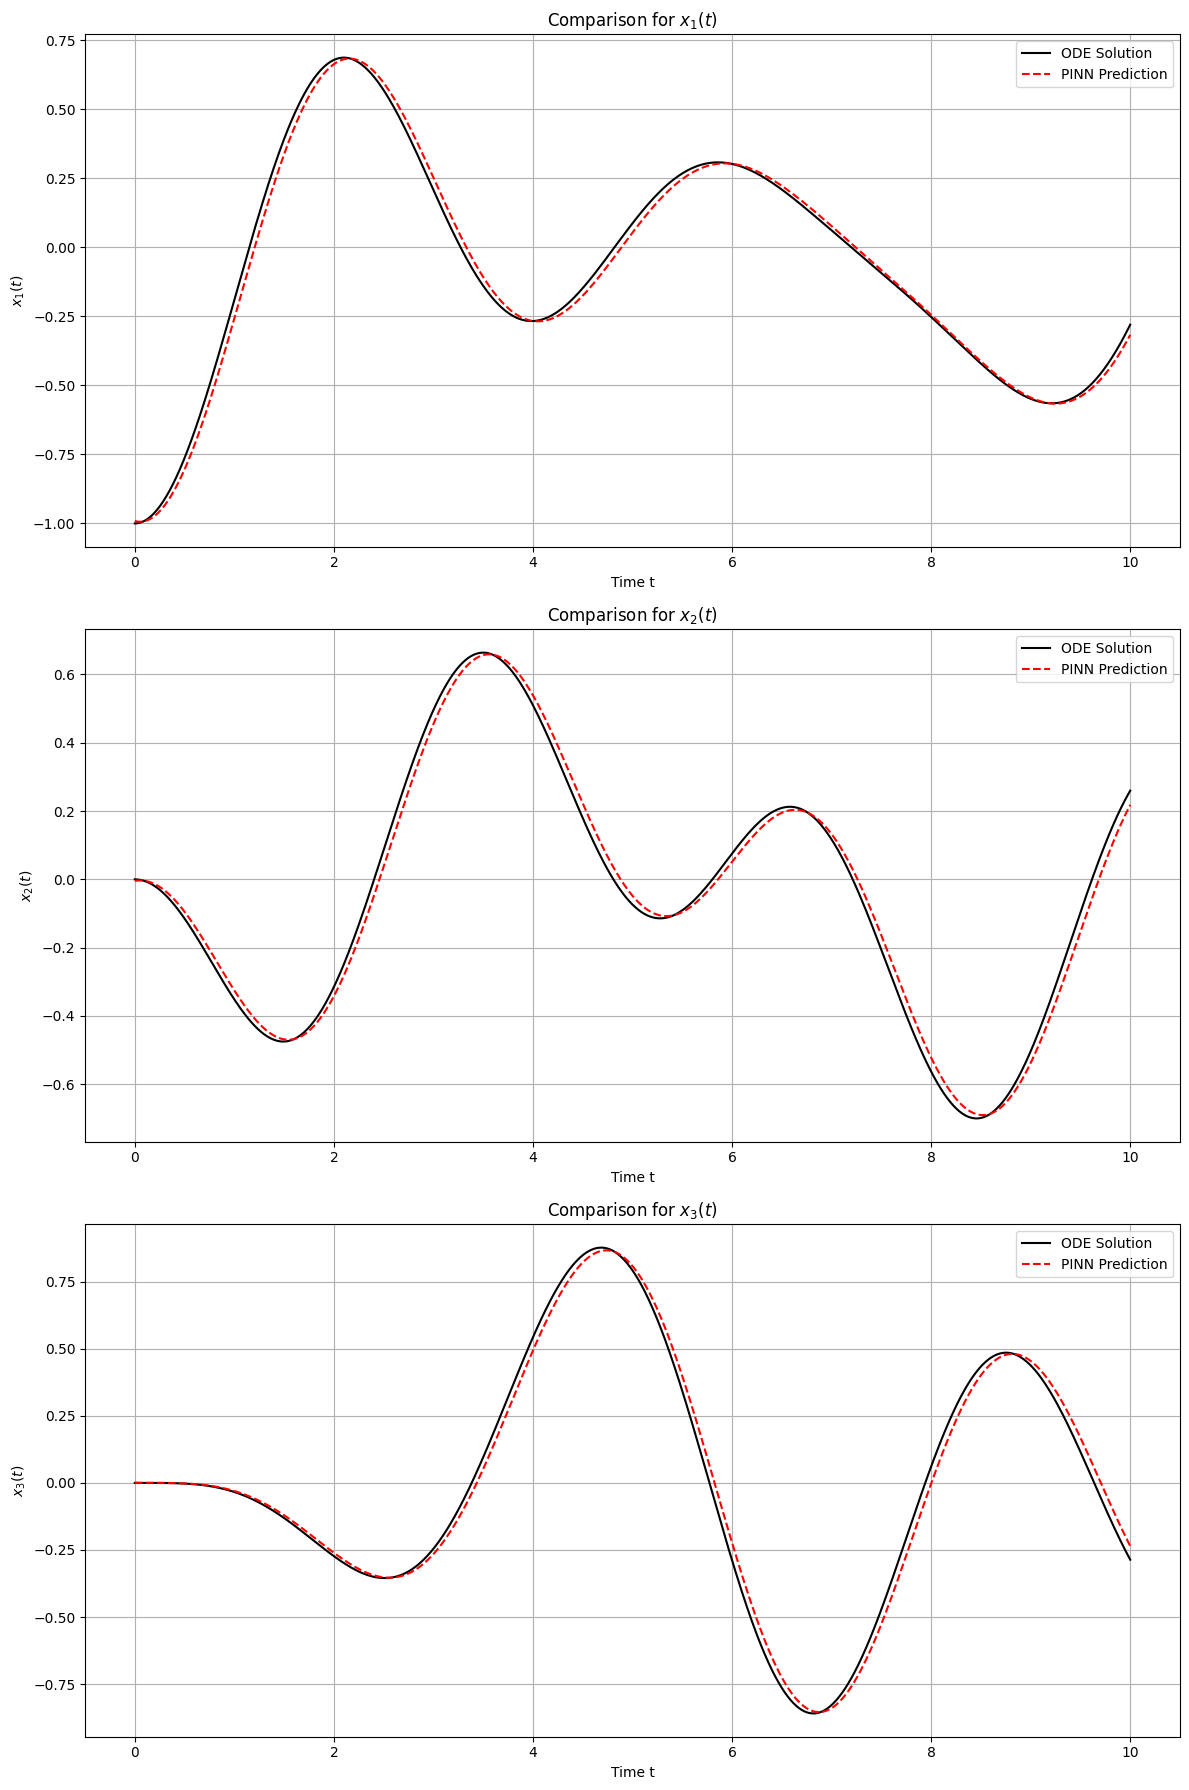

In [ ]:
plt.figure(figsize=(12, 18))

for i in range(N):
    plt.subplot(N, 1, i + 1)
    plt.plot(t_eval, solution.y[i], 'k-', label='ODE Solution')
    plt.plot(t_eval, x_pred[:, i], 'r--', label='PINN Prediction')
    plt.xlabel('Time t')
    plt.ylabel(f'$x_{i+1}(t)$')
    plt.title(f'Comparison for $x_{i+1}(t)$')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()